In [0]:
import glob
import os
import random
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import matplotlib.style as ms
import matplotlib.ticker as ticker
from matplotlib.pyplot import subplot
import seaborn as sns
from sklearn import model_selection
from sklearn import preprocessing
import IPython.display as ipd
sns.set_style("whitegrid")
import matplotlib.gridspec as gridspec
%matplotlib inline

In [2]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.models import load_model
import tensorflow as tf
from keras import backend as K
#K.set_image_dim_ordering('th')

# fix random seed for reproducibility
np.random.seed(7)

# Supress Tensorflow error logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

Using TensorFlow backend.


In [3]:
from google.colab import drive
drive.mount('/content/drive') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
import os
os.chdir('./drive/My Drive')
os.getcwd()

'/content/drive/My Drive'

In [0]:
sr = 22050

In [0]:
# load a wave data
def load_wave_data(audio_dir, file_name):
    file_path = os.path.join(audio_dir, file_name)
    x, fs = librosa.load(file_path, sr=sr)
    return x,fs

In [0]:
# change wave data to mel-stft
def calculate_melsp(x, n_fft=1024, hop_length=512):
    stft = np.abs(librosa.stft(x, n_fft=n_fft, hop_length=hop_length))**2
    log_stft = librosa.power_to_db(stft)
    melsp = librosa.feature.melspectrogram(S=log_stft,n_mels=128)
    return melsp

In [0]:
# display wave in plots
def show_wave(x):
    fig = plt.figure(figsize=(6,5))
    ax = fig.add_subplot(111)
    plt.plot(x)
    ax.set_xlabel('Time')
    ax.set_ylabel('Amplitude')
    plt.show()

In [0]:
# display wave in heatmap
def show_melsp(melsp, fs):
    librosa.display.specshow(melsp, y_axis='mel', x_axis='time', sr=fs)
   # plt.axis('off')
    plt.colorbar(format='%+2.0f dB')
    plt.show()

# **Sample Clips**

e_92.wav
22050
2.0651247165532878
wave size:(45536,)
melsp size:(128, 89)
samping rate:22050


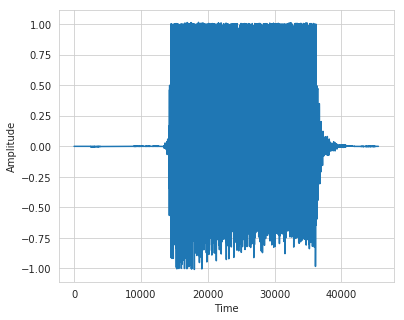

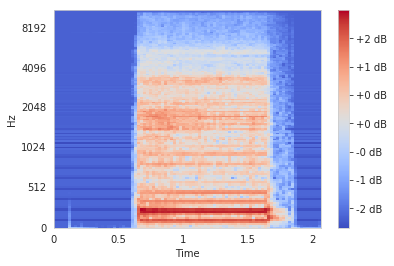

e_145.wav
22050
5.0
wave size:(110250,)
melsp size:(128, 216)
samping rate:22050


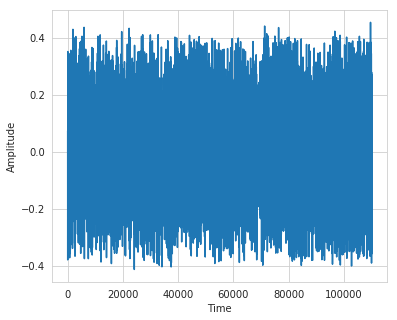

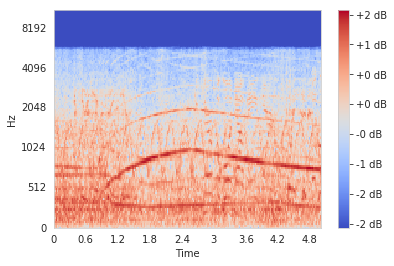

e_23.wav
22050
5.0
wave size:(110250,)
melsp size:(128, 216)
samping rate:22050


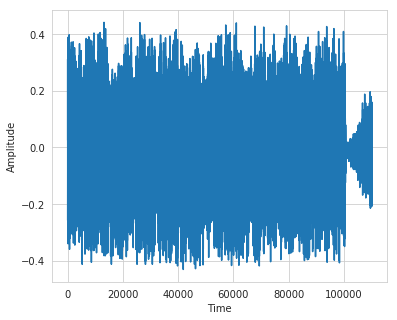

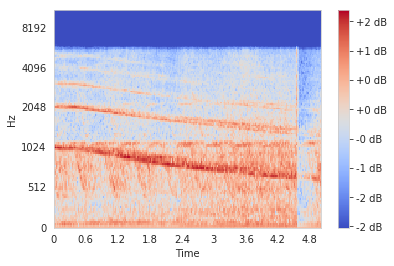

In [12]:
# example data
#plt.subplot(222)
audio_dir = './train_balanced/emergency/'
for file in os.listdir(audio_dir)[:3]:
  print(file)
  x, fs = load_wave_data(audio_dir,file)
  x = x[0:sr*5]
  print(fs)
  print(np.shape(x)[0]/float(sr))
  melsp = calculate_melsp(x)
  print("wave size:{0}\nmelsp size:{1}\nsamping rate:{2}".format(x.shape, melsp.shape, fs))
  show_wave(x)
  #pre_emph = 0.97
  #e_x = np.append(x[0], x[1:] - pre_emph * x[:-1])
  #show_wave(e_x)
  show_melsp(melsp, fs)
  #e_melsp = calculate_melsp(e_x)
  #show_melsp(e_melsp, fs)
  ipd.display(ipd.Audio(x, rate=fs))

79.wav
13.78125
wave size:(110250,)
melsp size:(128, 216)
samping rate:22050


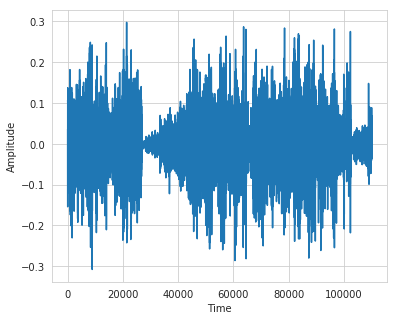

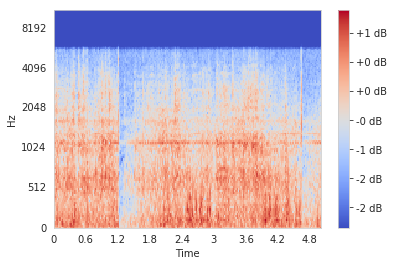

1105.wav
13.78125
wave size:(110250,)
melsp size:(128, 216)
samping rate:22050


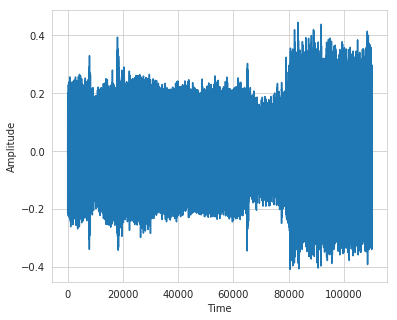

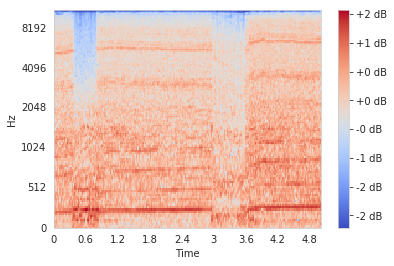

72.wav
13.78125
wave size:(110250,)
melsp size:(128, 216)
samping rate:22050


In [0]:
# example data
#plt.subplot(222)
audio_dir = './train_balanced/nonEmergency/'
for file in os.listdir(audio_dir)[:3]:
  print(file)
  x, fs = load_wave_data(audio_dir,file)
  x = x[0:sr*5]
  print(np.shape(x)[0]/8000.)
  melsp = calculate_melsp(x)
  print("wave size:{0}\nmelsp size:{1}\nsamping rate:{2}".format(x.shape, melsp.shape, fs))
  show_wave(x)
  show_melsp(melsp, fs)
  ipd.display(ipd.Audio(x, rate=fs))

In [0]:
# Read all the files from the dataset folder
path_em = './train_balanced/emergency'
path_nonem = './train_balanced/nonEmergency/'
#os.chdir('/home/swarup03/Study_Material/')
em_files = glob.glob(os.path.join(path_em, '*.wav'))
nonem_files = glob.glob(os.path.join(path_nonem, '*.wav'))

In [0]:
test_path_em = './eval_balanced/emergency'
test_path_nonem = './eval_balanced/nonEmergency/'

test_em_files = glob.glob(os.path.join(test_path_em, '*.wav'))
test_nonem_files = glob.glob(os.path.join(test_path_nonem, '*.wav'))

In [0]:
X_train = em_files + nonem_files[:int(1.5*len(em_files))]
a = np.ones(len(em_files))
b = np.zeros(int(1.5*len(em_files)))     
Y_train = np.hstack((a,b))
#len(X_train)

In [0]:
X_test = test_em_files + test_nonem_files[:int(1.5*len(test_em_files))]
Y_test = np.hstack((np.ones(len(test_em_files)), np.zeros(int(1.5*len(test_em_files)))))
#np.unique(Y_test)

# **Augmentation**

wave size:(110250,)
melsp size:(128, 216)
samping rate:22050


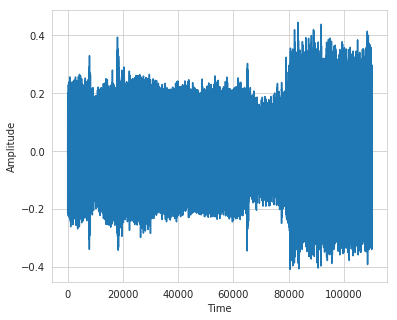

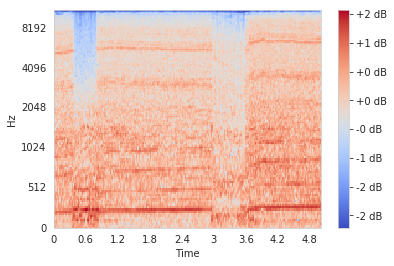

In [23]:
#Sample clip
x, fs = load_wave_data('./train_balanced/nonEmergency','1105.wav')
x = x[0:sr*5]
melsp = calculate_melsp(x)
print("wave size:{0}\nmelsp size:{1}\nsamping rate:{2}".format(x.shape, melsp.shape, fs))
show_wave(x)
show_melsp(melsp, fs)
ipd.display(ipd.Audio(x, rate=fs))

In [0]:
# data augmentation: add white noise
def add_white_noise(x, rate=0.002):
    return x + rate*np.random.randn(len(x))

wave size:(110250,)
melsp size:(128, 216)
samping rate:22050


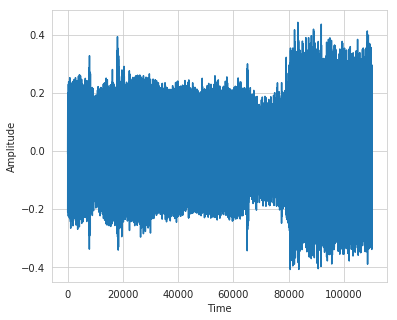

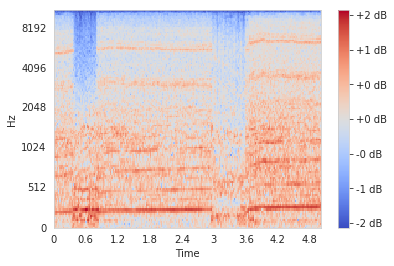

In [25]:
x_wn = add_white_noise(x)
melsp = calculate_melsp(x_wn)
print("wave size:{0}\nmelsp size:{1}\nsamping rate:{2}".format(x_wn.shape, melsp.shape, fs))
show_wave(x_wn)
show_melsp(melsp, fs)
ipd.Audio(x_wn, rate=fs)

In [0]:
# data augmentation: shift sound in timeframe
def shift_sound(x, rate=2):
    return np.roll(x, int(len(x)//rate))

wave size:(110250,)
melsp size:(128, 216)
samping rate:22050


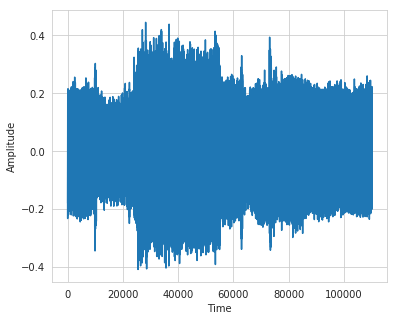

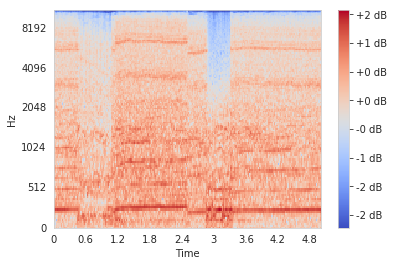

In [27]:
x_ss = shift_sound(x)
melsp = calculate_melsp(x_ss)
print("wave size:{0}\nmelsp size:{1}\nsamping rate:{2}".format(x_ss.shape, melsp.shape, fs))
show_wave(x_ss)
show_melsp(melsp, fs)
ipd.Audio(x_ss, rate=fs)

In [0]:
# data augmentation: stretch sound
def stretch_sound(x, rate=1.1):
    input_length = len(x)
    x = librosa.effects.time_stretch(x, rate)
    if len(x)>input_length:
        return x[:input_length]
    else:
        return np.pad(x, (0, max(0, input_length - len(x))), "constant")

wave size:(110250,)
melsp size:(128, 216)
samping rate:22050


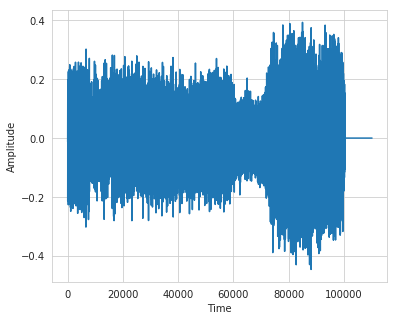

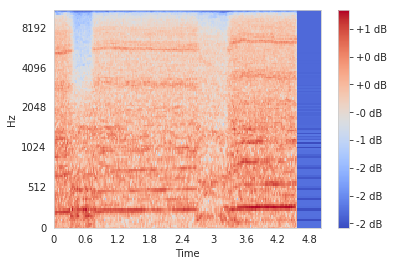

In [29]:
x_st = stretch_sound(x)
melsp = calculate_melsp(x_st)
print("wave size:{0}\nmelsp size:{1}\nsamping rate:{2}".format(x_st.shape, melsp.shape, fs))
show_wave(x_st)
show_melsp(melsp, fs)
ipd.Audio(x_st, rate=fs)

wave size:(110250,)
melsp size:(128, 216)
samping rate:22050


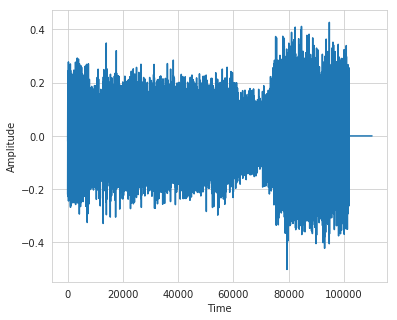

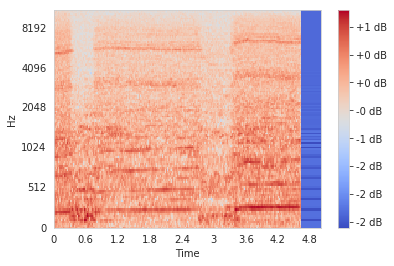

In [30]:
x, fs = load_wave_data('./train_balanced/nonEmergency','1105.wav')
length = np.shape(x)[0]/float(sr)
       # print(length)

x = x[0:int(sr*5)]
    
x = add_white_noise(x=x, rate=np.random.randint(1,50)/1000)
if np.random.choice((True,False)):
            x = shift_sound(x=x, rate=np.random.choice(np.arange(2,6)))
else:
            x = stretch_sound(x=x, rate=np.random.choice(np.arange(80,120))/100)
melsp = calculate_melsp(x)
print("wave size:{0}\nmelsp size:{1}\nsamping rate:{2}".format(x_st.shape, melsp.shape, fs))
show_wave(x)
show_melsp(melsp, fs)
ipd.Audio(x_st, rate=fs)

## Transform wav data to mel-stft array

Transform wav data files to mel-stft array, and save them as npz, separately with test, training and augmented training datasets.

In [0]:
freq = 128
time = 862
audio_dir =''
sr = 22050
from tqdm import tqdm

In [0]:
# save wave data in npz, with augmentation
def save_np_data(filename, x, y, aug=None, rates=None):
    np_data = np.zeros(freq*time*len(x)).reshape(len(x), freq, time)
    np_targets = np.zeros(len(y))
    #print(len(y))
    #print(len(y))
    for i in tqdm(range(len(y))):
        _x, fs = load_wave_data(audio_dir, x[i])
        #print(_x)
        length = np.shape(_x)[0]/float(sr)
       # print(length)
        if length > 5 and length <= 7.5:
          _x = _x[0:int(sr*5)]
        elif length >= 7.5:
          _x = _x[int(sr*2.5):int(sr*7.5)]
        else:
          continue
        if aug is not None:
            _x = aug(x=_x, rate=rates[i])
        _x = calculate_melsp(_x)
       # print(_x.shape)
        #ctr+=1
        try:
          np_data[i] = _x
          np_targets[i] = y[i]
        except:
          continue
    np.savez(filename, x=np_data, y=np_targets)

In [0]:
# save test dataset

save_np_data("esc_melsp_test4.npz", X_test,  Y_test)

In [0]:
save_np_data("esc_melsp_train_raw4.npz", X_train,Y_train)

100%|██████████| 1170/1170 [33:35<00:00,  1.76s/it]


In [0]:
rates = np.random.randint(1,50,len(X_train))/10000
save_np_data("esc_melsp_train_wn4.npz", X_train,  Y_train, aug=add_white_noise, rates=rates)

100%|██████████| 1170/1170 [26:53<00:00,  1.37s/it]


In [0]:
# save training dataset with sound shift
rates = np.random.choice(np.arange(2,6),len(Y_train))
save_np_data("esc_melsp_train_ss4.npz", X_train,  Y_train, aug=shift_sound, rates=rates)

100%|██████████| 1170/1170 [26:10<00:00,  1.37s/it]


In [0]:
# save training dataset with stretch
rates = np.random.choice(np.arange(80,120),len(Y_train))/100
save_np_data("esc_melsp_train_st4.npz", X_train,  Y_train, aug=stretch_sound, rates=rates)

100%|██████████| 1170/1170 [27:22<00:00,  1.45s/it]


In [0]:
# save training dataset with combination of white noise and shift or stretch


np_data = np.zeros(freq*time*len(X_train)).reshape(len(X_train), freq, time)
np_targets = np.zeros(len(Y_train))
for i in range(len(Y_train)):
        x, fs = load_wave_data(audio_dir, X_train[i])
        length = np.shape(x)[0]/float(sr)
       # print(length)
        if length > 5 and length <= 7.5:
          x = x[0:int(sr*5)]
        elif length >= 7.5:
          x = x[int(sr*2.5):int(sr*7.5)]
        else:
          continue
        x = add_white_noise(x=x, rate=np.random.randint(1,50)/1000)
        if np.random.choice((True,False)):
            x = shift_sound(x=x, rate=np.random.choice(np.arange(2,6)))
        else:
            x = stretch_sound(x=x, rate=np.random.choice(np.arange(80,120))/100)
        x = calculate_melsp(x)
        np_data[i] = x
        np_targets[i] = Y_train[i]
np.savez("esc_melsp_train_com4.npz", x=np_data, y=np_targets)

In [0]:
import keras
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Activation
from keras.layers import Conv2D, GlobalAveragePooling2D
from keras.layers import BatchNormalization, Add
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

In [0]:
# dataset files
train_files = ["esc_melsp_train_raw2.npz","esc_melsp_train_ss2.npz","esc_melsp_train_st2.npz","esc_melsp_train_wn2.npz","esc_melsp_train_com2.npz"]
             
test_file = "esc_melsp_test2.npz"

In [0]:
train_num = 1170
test_num = 352

In [0]:
x_train = np.zeros(freq*time*train_num*len(train_files)).reshape(train_num*len(train_files), freq, time)
y_train = np.zeros(train_num*len(train_files))


In [0]:
# load dataset
for i in range(len(train_files)):
    data = np.load(train_files[i])
    x_train[i*train_num:(i+1)*train_num] = data["x"]
    y_train[i*train_num:(i+1)*train_num] = data["y"]

In [38]:
x_train.shape

(5850, 128, 862)

In [0]:
# load test dataset
test_data = np.load(test_file)
test_data = np.load(test_file)
x_test = test_data["x"]
y_test = test_data["y"]

In [40]:
x_test = np.array(x_test)
y_test = np.array(y_test)
x_test.shape

(352, 128, 862)

In [41]:
np.unique(y_test)

array([0., 1.])

In [0]:
x_train = x_train.reshape(1170*5, 128,862, 1)
x_test = x_test.reshape(352, 128, 862, 1)

In [0]:
clas = {0: "Non-Emergency", 1: "Emergency"}

In [0]:
classes = 1

In [0]:
def cba(inputs, filters, kernel_size, strides):
    x = Conv2D(filters, kernel_size=kernel_size, strides=strides, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

In [0]:
# define CNN
inputs = Input(shape=(x_train.shape[1:]))

x_1 = cba(inputs, filters=32, kernel_size=(1,8), strides=(1,2))
x_1 = cba(x_1, filters=32, kernel_size=(8,1), strides=(2,1))
x_1 = cba(x_1, filters=64, kernel_size=(1,8), strides=(1,2))
x_1 = cba(x_1, filters=64, kernel_size=(8,1), strides=(2,1))

x_2 = cba(inputs, filters=32, kernel_size=(1,16), strides=(1,2))
x_2 = cba(x_2, filters=32, kernel_size=(16,1), strides=(2,1))
x_2 = cba(x_2, filters=64, kernel_size=(1,16), strides=(1,2))
x_2 = cba(x_2, filters=64, kernel_size=(16,1), strides=(2,1))

x_3 = cba(inputs, filters=32, kernel_size=(1,32), strides=(1,2))
x_3 = cba(x_3, filters=32, kernel_size=(32,1), strides=(2,1))
x_3 = cba(x_3, filters=64, kernel_size=(1,32), strides=(1,2))
x_3 = cba(x_3, filters=64, kernel_size=(32,1), strides=(2,1))

x_4 = cba(inputs, filters=32, kernel_size=(1,64), strides=(1,2))
x_4 = cba(x_4, filters=32, kernel_size=(64,1), strides=(2,1))
x_4 = cba(x_4, filters=64, kernel_size=(1,64), strides=(1,2))
x_4 = cba(x_4, filters=64, kernel_size=(64,1), strides=(2,1))

x = Add()([x_1, x_2, x_3, x_4])

x = cba(x, filters=128, kernel_size=(1,16), strides=(1,2))
x = cba(x, filters=128, kernel_size=(16,1), strides=(2,1))

x = GlobalAveragePooling2D()(x)
x = Dense(classes)(x)
x = Activation("sigmoid")(x)



In [52]:
model = Model(inputs, x)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 128, 862, 1)  0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 128, 431, 32) 288         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 128, 431, 32) 544         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 128, 431, 32) 1056        input_2[0][0]                    
____________________________________________________________________________________________

In [0]:
# initiate Adam optimizer
opt = keras.optimizers.adam(lr=0.00001, decay=1e-6, amsgrad=True)

# Let's train the model using Adam with amsgrad
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [0]:
# between class data generator
class MixupGenerator():
    def __init__(self, x_train, y_train, batch_size=16, alpha=0.3, shuffle=True):
        self.x_train = x_train
        self.y_train = y_train
        self.batch_size = batch_size
        self.alpha = alpha
        self.shuffle = shuffle
        self.sample_num = len(x_train)

    def __call__(self):
        while True:
            indexes = self.__get_exploration_order()
            itr_num = int(len(indexes) // (self.batch_size * 2))

            for i in range(itr_num):
                batch_ids = indexes[i * self.batch_size * 2:(i + 1) * self.batch_size * 2]
                x, y = self.__data_generation(batch_ids)

                yield x, y

    def __get_exploration_order(self):
        indexes = np.arange(self.sample_num)

        if self.shuffle:
            np.random.shuffle(indexes)

        return indexes

    def __data_generation(self, batch_ids):
        _, h, w, c = self.x_train.shape
        _ = self.y_train.shape
        x1 = self.x_train[batch_ids[:self.batch_size]]
        x2 = self.x_train[batch_ids[self.batch_size:]]
        y1 = self.y_train[batch_ids[:self.batch_size]]
        y2 = self.y_train[batch_ids[self.batch_size:]]
        l = np.random.beta(self.alpha, self.alpha, self.batch_size)
        x_l = l.reshape(self.batch_size, 1, 1, 1)
        y_l = l.reshape(self.batch_size)

        x = x1 * x_l + x2 * (1 - x_l)
        y = y1 * y_l + y2 * (1 - y_l)

        return x, y

In [56]:
# train model
batch_size = 25
epochs = 10

training_generator = MixupGenerator(x_train, y_train)()
model.fit_generator(generator=training_generator,
                    steps_per_epoch=x_train.shape[0] // batch_size,
                    validation_data=(x_test, y_test),
                    epochs=epochs, 
                    verbose=1,
                    shuffle=True)

Epoch 1/20
234/234 [==============================] - 342s 1s/step - loss: 0.5706 - acc: 0.3900 - val_loss: 0.5039 - val_acc: 0.7812
Epoch 2/20
234/234 [==============================] - 332s 1s/step - loss: 0.5163 - acc: 0.4367 - val_loss: 0.4926 - val_acc: 0.7472
Epoch 3/20
234/234 [==============================] - 331s 1s/step - loss: 0.4967 - acc: 0.4306 - val_loss: 0.4575 - val_acc: 0.7841
Epoch 4/20
234/234 [==============================] - 331s 1s/step - loss: 0.4754 - acc: 0.4434 - val_loss: 0.6165 - val_acc: 0.7102
Epoch 5/20
234/234 [==============================] - 331s 1s/step - loss: 0.4672 - acc: 0.4439 - val_loss: 0.4714 - val_acc: 0.7955
Epoch 6/20
234/234 [==============================] - 331s 1s/step - loss: 0.4675 - acc: 0.4485 - val_loss: 0.4472 - val_acc: 0.7812
Epoch 7/20
234/234 [==============================] - 331s 1s/step - loss: 0.4510 - acc: 0.4538 - val_loss: 0.5945 - val_acc: 0.7330
Epoch 8/20
234/234 [==============================] - 331s 1s/step - 

KeyboardInterrupt: ignored

In [0]:
from sklearn.model_selection import train_test_split, StratifiedKFold
def load_data_kfold(k):
    
    folds = list(StratifiedKFold(n_splits=k, shuffle=True, random_state=1).split(x_train, y_train))
    
    return folds

k = 3
folds = load_data_kfold(k)

In [0]:
for j, (train_idx, val_idx) in enumerate(folds):
    
    print('\nFold ',j)
    X_train_cv = x_train[train_idx]
    y_train_cv = y_train[train_idx]
    X_valid_cv = x_train[val_idx]
    y_valid_cv= y_train[val_idx]
    

    model = model
    model.fit(
                X_train_cv,y_train_cv,
                batch_size=25,
                epochs=15,
                shuffle=True,
                verbose=1,
                validation_data = (X_valid_cv, y_valid_cv))
    
    print(model.evaluate(X_valid_cv, y_valid_cv))


Fold  0
Train on 3899 samples, validate on 1951 samples
Epoch 1/15


In [0]:
from sklearn.metrics import classification_report

In [0]:
from keras.models import load_model
model = load_model('models/esc50_.14_0.4147_0.8409.hdf5')

In [0]:
from keras.utils import plot_model
plot_model(model, to_file='model.png',show_shapes = True)

In [0]:
y_pred = model.predict(x_test)

In [0]:
y_pred = [1 if i>=0.5 else 0 for i in y_pred]

In [0]:

y_test = y_test.reshape(352,)
y_test = [int(i) for i in y_test]
y_test = np.array(y_test)

In [63]:
cr = classification_report(y_test, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.84      0.90      0.87       211
           1       0.83      0.75      0.79       141

    accuracy                           0.84       352
   macro avg       0.84      0.83      0.83       352
weighted avg       0.84      0.84      0.84       352



In [64]:


def show_values(pc, fmt="%.2f", **kw):
 
    pc.update_scalarmappable()
    ax = pc.axes
    for p, color, value in zip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.all(color[:3] > 0.5):
            color = (0.0, 0.0, 0.0)
        else:
            color = (1.0, 1.0, 1.0)
        ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)


def cm2inch(*tupl):
    '''
    Specify figure size in centimeter in matplotlib
    Source: https://stackoverflow.com/a/22787457/395857
    By gns-ank
    '''
    inch = 2.54
    if type(tupl[0]) == tuple:
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)


def heatmap(AUC, title, xlabel, ylabel, xticklabels, yticklabels, figure_width=40, figure_height=20, correct_orientation=False, cmap='RdBu'):
    '''
    Inspired by:
    - https://stackoverflow.com/a/16124677/395857 
    - https://stackoverflow.com/a/25074150/395857
    '''

    # Plot it out
    fig, ax = plt.subplots()    
    #c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap='RdBu', vmin=0.0, vmax=1.0)
    c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap=cmap)

    # put the major ticks at the middle of each cell
    ax.set_yticks(np.arange(AUC.shape[0]) + 0.5, minor=False)
    ax.set_xticks(np.arange(AUC.shape[1]) + 0.5, minor=False)

    # set tick labels
    #ax.set_xticklabels(np.arange(1,AUC.shape[1]+1), minor=False)
    ax.set_xticklabels(xticklabels, minor=False)
    ax.set_yticklabels(yticklabels, minor=False)

    # set title and x/y labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)      

    # Remove last blank column
    plt.xlim( (0, AUC.shape[1]) )

    # Turn off all the ticks
    ax = plt.gca()    
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    # Add color bar
    plt.colorbar(c)

    # Add text in each cell 
    show_values(c)

    # Proper orientation (origin at the top left instead of bottom left)
    if correct_orientation:
        ax.invert_yaxis()
        ax.xaxis.tick_top()       

    # resize 
    fig = plt.gcf()
    #fig.set_size_inches(cm2inch(40, 20))
    #fig.set_size_inches(cm2inch(40*4, 20*4))
    fig.set_size_inches(cm2inch(figure_width, figure_height))



def plot_classification_report(classification_report, title='Classification report ', cmap='RdBu'):
    '''
    Plot scikit-learn classification report.
    Extension based on https://stackoverflow.com/a/31689645/395857 
    '''
    lines = classification_report.split('\n')
    #print(lines)
    classes = []
    plotMat = []
    support = []
    class_names = []
    print(len(lines))
    for line in lines[2 : (len(lines))]:
        
        t = line.strip().split()
        print(t)
        if len(t) < 2: continue
        classes.append(t[0])
        print(t)
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        print(v)
        plotMat.append(v)

    print('plotMat: {0}'.format(plotMat))
    print('support: {0}'.format(support))

    xlabel = 'Metrics'
    ylabel = 'Classes'
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup) for idx, sup  in enumerate(support)]
    figure_width = 25
    figure_height = len(class_names) + 7
    correct_orientation = False
    heatmap(np.array(plotMat), title, xlabel, ylabel, xticklabels, yticklabels, figure_width, figure_height, correct_orientation, cmap=cmap)


def main():
    sampleClassificationReport = """precision    recall  f1-score   support

           0       0.77      0.89      0.82       211
           1       0.78      0.60      0.67       141       
"""

    plot_classification_report(sampleClassificationReport)
    plt.savefig('test_plot_classif_report5.png', dpi=200, format='png', bbox_inches='tight')
    plt.close()

if __name__ == "__main__":
    main()

5
['0', '0.77', '0.89', '0.82', '211']
['0', '0.77', '0.89', '0.82', '211']
[0.77, 0.89, 0.82]
['1', '0.78', '0.60', '0.67', '141']
['1', '0.78', '0.60', '0.67', '141']
[0.78, 0.6, 0.67]
[]
plotMat: [[0.77, 0.89, 0.82], [0.78, 0.6, 0.67]]
support: [211, 141]


In [0]:
from sklearn.metrics import roc_curve,auc

In [0]:
y_conf =  model.predict(x_test)
y_conf = y_conf.reshape(352,)
#y_conf

In [0]:
from sklearn.metrics import roc_curve,auc

In [0]:
fpr, tpr, threshold = roc_curve(y_test,y_conf,pos_label=1)

In [69]:
roc_auc = auc(fpr, tpr)
roc_auc

0.8866424657994689

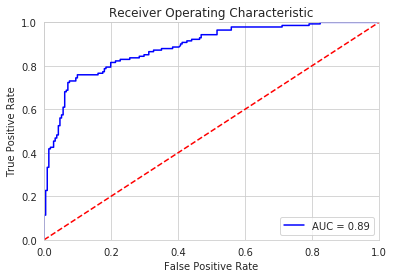

In [70]:

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


In [0]:
classes = {0: 'Non_Emergency', 1: 'Emergency'}

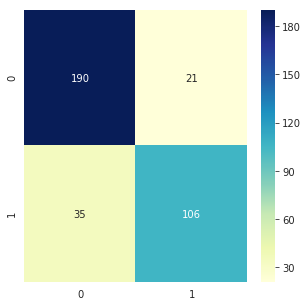

In [72]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,y_pred)
df_cm = pd.DataFrame(cm, index = classes,
                  columns = classes)
plt.figure(figsize = (5,5))
sns.heatmap(df_cm,annot=True, fmt='1.0f', cmap='YlGnBu')

In [0]:
model.save('CNN_ESR_0.8031.h5')